In [22]:
# Cell 1
# ---------------------------------------------------
# Download required dependencies and import needed libraries
# ---------------------------------------------------

# --- Install Commands ---
%pip install xgboost
%pip install torch skorch
%pip install torchvision
%pip install kaggle
%pip install kagglehub
%pip install kagglehub[pandas-datasets]

# --- Standard Libraries ---
import os
import re
import time
import random
import numpy as np
import pandas as pd
from collections import Counter

# --- Visualizing Data ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Scikit-learn Tools ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Deep Learning Tools ---
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier

# --- Kagglehub for Dataset ---
import kagglehub



Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Cell 2
# ---------------------------------------------------
# Functions
# ---------------------------------------------------

# Downloads CSV from kagglehub, optionally applying feature vector, optionally applying input name
def get_df_from_kaggle_api(kaggle_filepath: str, csv_filename: str = None, feature_vector: list[str] = None) -> pd.DataFrame:
    dataset_path = kagglehub.dataset_download(kaggle_filepath)
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {dataset_path}")
    
    csv_path = os.path.join(dataset_path, csv_files[0])
    if csv_filename is not None:
        updated_name_path = os.path.join(dataset_path, csv_filename)
        os.rename(csv_path, updated_name_path)
        csv_path = updated_name_path
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    print("Path to dataset file:", csv_path)

    df = pd.read_csv(csv_path).dropna()
    if feature_vector is not None:
        df = df[feature_vector]
    return df

# Simple math for getting a consistent output
def get_scaling_factor_for_result(size: int, desired_size=10_000) -> float:
    alpha = 1.00
    if desired_size < size:
        alpha = desired_size / size
    return alpha

# Math for scaling lists to desired size
def scale_list(list_to_scale: list, scaling_factor: float):
    if scaling_factor < 1.0:
        sample_size = int(len(list_to_scale) * scaling_factor)
        list_to_scale = random.sample(list_to_scale, sample_size)
    return list_to_scale

# Helper function to tokenize text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return text.lower().split()

# Helper function to build vocabulary from training data
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Helper function to convert text to sequence of integers
def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# Helper function to pad or truncate sequences to a fixed maximum length
def pad_sequence_to_length(seq, max_len):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        padding = torch.zeros(max_len - len(seq), dtype=torch.long)
        return torch.cat([seq, padding])
    
# Retrieves the best possible model given parameters
def get_best_model(models=None, X_train=None, y_train=None, cv=5, scoring='accuracy'):
    if models is None or X_train is None or y_train is None: 
        raise ValueError("Models, X_train, and y_train must be provided.")
    
    results = {}

    for name, model, in models.items():
        print(f"Evaluating model: {name}")
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        results[name] = scores.mean()
        print(f"{name}: {scoring} = {scores.mean():.4f} (std: {scores.std():.4f})")

    best_model = max(results, key=results.get)
    print(f"\nBest model: {best_model} with {scoring} = {results[best_model]:.4f}")
    return best_model

# Function to optimize XGBoost hyperparameters
def optimize_xgboost(X_train, y_train, X_val, y_val):
    """
    Tests various XGBoost configurations and returns the best model.
    
    Args:
        X_train: Training features (TF-IDF vectors)
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        
    Returns:
        tuple: (best_model, best_params, test_accuracy)
    """
    print("Optimizing XGBoost hyperparameters...")
    
    # Define parameter grid to search - reduced for faster execution
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200],
    }
    
    # For each parameter, test all values while keeping others at default
    best_params = {}
    best_score = 0
    
    # For each parameter
    for param_name, param_values in param_grid.items():
        print(f"\nTesting {param_name}:")
        param_scores = []
        
        # For each value of this parameter
        for value in param_values:
            # Create a model with this parameter value
            params = {**best_params, param_name: value}
            model = XGBClassifier(
                random_state=applied_state,
                eval_metric='logloss',
                **params
            )
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Evaluate on validation set
            y_pred = model.predict(X_val)
            score = accuracy_score(y_val, y_pred)
            param_scores.append((value, score))
            
            print(f"  {param_name}={value}: accuracy={score:.4f}")
        
        # Find the best value for this parameter
        best_value, best_param_score = max(param_scores, key=lambda x: x[1])
        best_params[param_name] = best_value
        best_score = best_param_score
        
        print(f"Best {param_name}: {best_value} (accuracy: {best_param_score:.4f})")
    
    print("\nBest XGBoost parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Train final model with best parameters
    final_model = XGBClassifier(
        random_state=applied_state,
        eval_metric='logloss',
        **best_params
    )
    final_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = final_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred)
    
    print(f"\nFinal XGBoost model validation accuracy: {val_accuracy:.4f}")
    
    return final_model, best_params, val_accuracy


# Function to optimize CNN hyperparameters
def optimize_cnn(X_train, y_train, X_val, y_val, vocab_size, device):
    """
    Tests various CNN configurations and returns the best model.
    
    Args:
        X_train: Training text sequences (tensor)
        y_train: Training labels (tensor)
        X_val: Validation text sequences (tensor)
        y_val: Validation labels (tensor)
        vocab_size: Size of vocabulary
        device: Device to use (cuda/cpu)
        
    Returns:
        tuple: (best_model, best_params, val_accuracy)
    """
    print("Optimizing CNN hyperparameters...")
    
    # Define parameter grid to search - reduced for faster execution
    param_grid = {
        'module__embed_dim': [50, 100],
        'module__kernel_sizes': [[3, 4, 5], [2, 3, 4]],
        'module__dropout': [0.3, 0.5],
        'lr': [0.001, 0.005],
    }
    
    # Dictionary to store best parameters
    best_params = {
        'module__embed_dim': 100,
        'module__kernel_sizes': [3, 4, 5],
        'module__num_filters': 100,
        'module__dropout': 0.5,
        'lr': 0.001,
        'batch_size': 64,
    }
    
    best_score = 0
    
    # For each parameter
    for param_name, param_values in param_grid.items():
        print(f"\nTesting {param_name}:")
        param_scores = []
        
        # For each value of this parameter
        for value in param_values:
            # Update parameters dict with this value
            current_params = best_params.copy()
            current_params[param_name] = value
            
            # Create CNN model with these parameters
            net = NeuralNetClassifier(
                module=CNNTextClassifier,
                module__vocab_size=vocab_size,
                module__output_dim=2,
                criterion=nn.CrossEntropyLoss,
                optimizer=optim.Adam,
                max_epochs=3,  # Reduce epochs for faster testing
                iterator_train__shuffle=True,
                device=device,
                **current_params  # Apply current parameter set
            )
            
            # Train the model
            net.fit(X_train, y_train)
            
            # Evaluate on validation set
            y_pred = net.predict(X_val)
            score = accuracy_score(y_val.numpy(), y_pred)
            param_scores.append((value, score))
            
            print(f"  {param_name}={value}: accuracy={score:.4f}")
        
        # Find best value for this parameter
        best_value, best_param_score = max(param_scores, key=lambda x: x[1])
        best_params[param_name] = best_value
        best_score = best_param_score
        
        print(f"Best {param_name}: {best_value} (accuracy: {best_param_score:.4f})")
    
    print("\nBest CNN parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Train final model with best parameters
    final_model = NeuralNetClassifier(
        module=CNNTextClassifier,
        module__vocab_size=vocab_size,
        module__output_dim=2,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.Adam,
        max_epochs=5,  # Use more epochs for final model
        iterator_train__shuffle=True,
        device=device,
        **best_params  # Apply best parameter set
    )
    
    # Train the final model
    final_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = final_model.predict(X_val)
    val_accuracy = accuracy_score(y_val.numpy(), y_pred)
    
    print(f"\nFinal CNN model validation accuracy: {val_accuracy:.4f}")
    
    return final_model, best_params, val_accuracy

# Function to predict sentiment using both CNN and XGBoost
def demo_predict(review, vocab, max_seq_length, net, vectorizer, xgb_model, device):
    review = review.lower()

    # ===== CNN PREDICTION =====
    # Convert review text into sequence of vocab indices
    tokens = text_to_sequence(review, vocab)
    tokens = pad_sequence_to_length(torch.tensor(tokens), max_seq_length)
    tokens = tokens.unsqueeze(0).long()  # Add batch dimension and ensure long type

    # Move to device (CPU or GPU)
    tokens = tokens.to(device)

    # CNN prediction
    net.module_.eval()  # Set model to eval mode
    with torch.no_grad():
        cnn_output = net.module_(tokens)
        cnn_pred = torch.argmax(cnn_output, dim=1).item()

    # ===== XGBoost PREDICTION =====
    # Transform review into TF-IDF vector
    tfidf_vec = vectorizer.transform([review])

    # XGBoost prediction
    xgb_pred = xgb_model.predict(tfidf_vec)[0]

    # ===== OUTPUT =====
    sentiment_labels = ["Negative", "Positive"]
    print(f"Review: {review}")
    print(f"CNN Prediction: {sentiment_labels[cnn_pred]}")
    print(f"XGBoost Prediction: {sentiment_labels[xgb_pred]}")

In [24]:
# Cell 3
# ---------------------------------------------------
# Download CSV and apply filters as desired. Store df into positive and negative lists.
# ---------------------------------------------------

positive_sentiment = []
negative_sentiment = []
applied_state = 2

# Amazon processing
amazon_data_path = "arhamrumi/amazon-product-reviews"
amazon_csv_custom_name = "amazon_review_data.csv"
amazon_features_vector = ["Score", "Text"]
amazon_csv_df = get_df_from_kaggle_api(amazon_data_path, amazon_csv_custom_name, amazon_features_vector)
del amazon_features_vector, amazon_csv_custom_name, amazon_data_path

# Filtering for Mostly Positive Reviews
amazon_data_sample_size = get_scaling_factor_for_result(amazon_csv_df.shape[0])
amazon_rating_threshhold = 4
positive_sentiment.extend(
    amazon_csv_df.loc[amazon_csv_df["Score"] >= amazon_rating_threshhold, "Text"]
    .sample(frac=amazon_data_sample_size, random_state=applied_state)
    .tolist()
)
# Filtering for Mostly Negative Reviews
negative_sentiment.extend(
    amazon_csv_df.loc[amazon_csv_df["Score"] < amazon_rating_threshhold, "Text"]
    .sample(frac=amazon_data_sample_size, random_state=applied_state)
    .tolist()
)
del amazon_csv_df, amazon_data_sample_size, amazon_rating_threshhold

# booking processing
booking_data_path = "jiashenliu/515k-hotel-reviews-data-in-europe"
booking_csv_custom_name = "booking_review_data.csv"
booking_features_vector = ["Positive_Review", "Negative_Review"]
booking_text_df = get_df_from_kaggle_api(booking_data_path, booking_csv_custom_name, booking_features_vector)
del booking_data_path, booking_csv_custom_name, booking_features_vector

booking_data_sample_size = get_scaling_factor_for_result(booking_text_df.shape[0])
positive_sentiment.extend(
    booking_text_df["Positive_Review"]
    .sample(frac=booking_data_sample_size, random_state=applied_state)
    .tolist()
)
negative_sentiment.extend(
    booking_text_df["Negative_Review"]
    .sample(frac=booking_data_sample_size, random_state=applied_state)
    .tolist()
)
del booking_data_sample_size, booking_text_df

# Twitter processing
twitter_negative_data_path = "yashdogra/toxic-tweets"
twitter_csv_custom_name = "twitter_negative_tweets.csv"
twitter_features_vector = ["tweet"]
twitter_text_df = get_df_from_kaggle_api(twitter_negative_data_path, twitter_csv_custom_name, twitter_features_vector)
del twitter_negative_data_path, twitter_csv_custom_name, twitter_features_vector

twitter_sample_size = get_scaling_factor_for_result(twitter_text_df.shape[0])
negative_sentiment.extend(
    twitter_text_df.iloc[:, 0]
    .sample(frac=twitter_sample_size, random_state=applied_state)
    .tolist()
)
del twitter_text_df, twitter_sample_size

print(f"\nSize of positive_sentiment: {len(positive_sentiment)} Size of negative_sentiment: {len(negative_sentiment)}")


Path to dataset file: C:\Users\oweni\.cache\kagglehub\datasets\arhamrumi\amazon-product-reviews\versions\1\amazon_review_data.csv
Path to dataset file: C:\Users\oweni\.cache\kagglehub\datasets\jiashenliu\515k-hotel-reviews-data-in-europe\versions\1\booking_review_data.csv
Path to dataset file: C:\Users\oweni\.cache\kagglehub\datasets\yashdogra\toxic-tweets\versions\1\twitter_negative_tweets.csv

Size of positive_sentiment: 17807 Size of negative_sentiment: 22193


In [25]:
# Cell 4
# ---------------------------------------------------
# Creating vectors to be used by model
# ---------------------------------------------------
p_len = len(positive_sentiment)
n_len = len(negative_sentiment)
print(f"Pre-sample Positive: {p_len}")
print(f"Pre-sample Negative: {n_len}")

positive_scaling_factor = get_scaling_factor_for_result(p_len)
negative_scaling_factor = get_scaling_factor_for_result(n_len)
del p_len, n_len

# Scale size of the lists
positive_sentiment = scale_list(positive_sentiment, positive_scaling_factor)
negative_sentiment = scale_list(negative_sentiment, negative_scaling_factor)
del positive_scaling_factor, negative_scaling_factor

# Balance the dataset
min_samples = min(len(positive_sentiment), len(negative_sentiment))
positive_sentiment = positive_sentiment[:min_samples]
negative_sentiment = negative_sentiment[:min_samples]
del min_samples

# Lowercase the text
positive_sentiment = [text.lower() for text in positive_sentiment]
negative_sentiment = [text.lower() for text in negative_sentiment]

print(f"Post-sample Positive: {len(positive_sentiment)}")
print(f"Post-sample Negative: {len(negative_sentiment)}")

# Combine into final model vectors
final_texts = positive_sentiment + negative_sentiment
final_labels = [1] * len(positive_sentiment) + [0] * len(negative_sentiment)
del positive_sentiment, negative_sentiment

Pre-sample Positive: 17807
Pre-sample Negative: 22193
Post-sample Positive: 10000
Post-sample Negative: 10000


In [26]:
# Cell 5
# ---------------------------------------------------
# Split data into vectors
# ---------------------------------------------------

print(f"Total Samples Available: {len(final_texts)}")

# Split the raw text data into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    final_texts,
    final_labels,
    test_size=0.2,
    random_state=applied_state,
    stratify=final_labels
)
del final_texts, final_labels

# Apply TF-IDF vectorization separately to training and testing sets
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

print(f"Training Samples: {len(X_train_raw)}")
print(f"Testing Samples: {len(X_test_raw)}")

Total Samples Available: 20000
Training Samples: 16000
Testing Samples: 4000


In [27]:
# Cell 6
# ---------------------------------------------------
# Build vocabulary and prepare sequences for CNN training
# ---------------------------------------------------

max_seq_length = 100

vocab = build_vocab(X_train_raw, min_freq=2)

print(f"Vocabulary size: {len(vocab)} words")

# Convert raw text reviews into sequences of integer IDs
X_train_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_train_raw]
X_test_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_test_raw]
del X_train_raw, X_test_raw

# Pad or truncate each sequence to the maximum length
X_train_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_train_seq]
X_test_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_test_seq]

# Stack sequences into full 2D tensors (batch_size, max_seq_length)
X_train_tensor = torch.stack(X_train_seq).type(torch.long)
X_test_tensor = torch.stack(X_test_seq).type(torch.long)
del X_train_seq, X_test_seq

# Convert labels into tensor format
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Testing tensor shape: {X_test_tensor.shape}")

Vocabulary size: 11386 words
Training tensor shape: torch.Size([16000, 100])
Testing tensor shape: torch.Size([4000, 100])


In [28]:
# Cell 7
# ---------------------------------------------------
# Define CNN-based text classification model
# ---------------------------------------------------

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)          # (batch_size, seq_length, embed_dim)
        embedded = embedded.permute(0, 2, 1)   # (batch_size, embed_dim, seq_length)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # Max-over-time pooling
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        output = self.fc(cat)
        return output

# Set up Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=CNNTextClassifier,
    module__vocab_size=len(vocab),
    module__embed_dim=100,
    module__output_dim=2,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=0.001,
    batch_size=64,
    max_epochs=10,
    iterator_train__shuffle=True,
    device=device,
)

print(f"Upgraded CNN model ready! Using device: {device}")


Upgraded CNN model ready! Using device: cpu


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4372       0.8756        0.3005  13.4183
      2        0.2887       0.9028        0.2562  10.9851
      3        0.2284       0.9044        0.2457  9.8837
      4        0.1823       0.9078        0.2488  10.9313
      5        0.1506       0.9066        0.2479  10.5589
      6        0.1292       0.9131        0.2416  10.0117
      7        0.1143       0.9050        0.2778  10.3625
Training completed in 77.98 seconds.
Optimizing CNN hyperparameters...

Testing module__embed_dim:
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5032       0.8463        0.3423  7.7221
      2        0.3485       0.8739        0.2832  6.8085
      3        0.2793       0.8868        0.2587  7.6085
  module__embed_dim=50: accuracy=0.8900
  epoch    train_loss    valid_acc    valid_loss     du

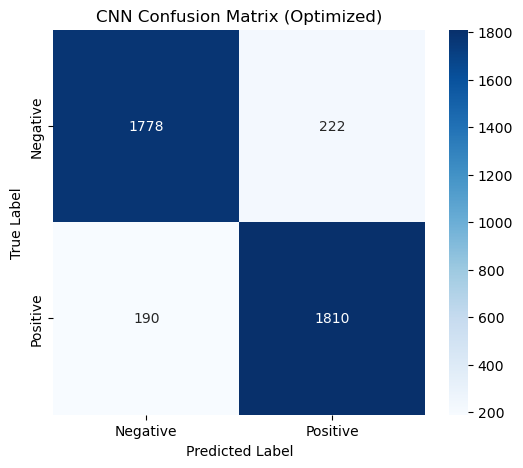

In [29]:
# Cell 8
# ---------------------------------------------------
# Train the CNN model
# ---------------------------------------------------

# Start timer
start_time = time.time()

# Fit the model
net.fit(X_train_tensor, y_train_tensor)

# End timer
end_time = time.time()
training_time = end_time - start_time

# Summary
print(f"Training completed in {training_time:.2f} seconds.")

# Cell 9
# ---------------------------------------------------
# Train and optimize the CNN model
# ---------------------------------------------------

# Define CNN model class
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)          # (batch_size, seq_length, embed_dim)
        embedded = embedded.permute(0, 2, 1)   # (batch_size, embed_dim, seq_length)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # Max-over-time pooling
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        output = self.fc(cat)
        return output

# Split the training data into training and validation sets for hyperparameter tuning
X_train_tensor_split, X_val_tensor, y_train_tensor_split, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.15, random_state=applied_state, stratify=y_train_tensor
)

# Start timer
start_time = time.time()

# Optimize CNN hyperparameters
best_cnn_model, best_cnn_params, cnn_val_accuracy = optimize_cnn(
    X_train_tensor_split, 
    y_train_tensor_split, 
    X_val_tensor, 
    y_val_tensor, 
    len(vocab), 
    device
)

# Train the final model on the full training set
final_cnn = NeuralNetClassifier(
    module=CNNTextClassifier,
    module__vocab_size=len(vocab),
    module__output_dim=2,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    max_epochs=10,
    iterator_train__shuffle=True,
    device=device,
    **best_cnn_params  # Use the best parameters found
)

print("Training final CNN model on the full training set...")
final_cnn.fit(X_train_tensor, y_train_tensor)

# End timer
end_time = time.time()
training_time = end_time - start_time

# Evaluate on the test set
y_pred_cnn = final_cnn.predict(X_test_tensor)
y_test_np = y_test_tensor.numpy()

# Accuracy
test_accuracy_cnn = accuracy_score(y_test_np, y_pred_cnn)
print(f"\nFinal CNN Model Training completed in {training_time:.2f} seconds.")
print(f"Test Accuracy: {test_accuracy_cnn:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_cnn, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_cnn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix (Optimized)")
plt.show()


Optimizing XGBoost hyperparameters...

Testing learning_rate:
  learning_rate=0.01: accuracy=0.8067
  learning_rate=0.1: accuracy=0.8792
Best learning_rate: 0.1 (accuracy: 0.8792)

Testing max_depth:
  max_depth=3: accuracy=0.8604
  max_depth=5: accuracy=0.8754
  max_depth=7: accuracy=0.8829
Best max_depth: 7 (accuracy: 0.8829)

Testing n_estimators:
  n_estimators=100: accuracy=0.8829
  n_estimators=200: accuracy=0.8992
Best n_estimators: 200 (accuracy: 0.8992)

Best XGBoost parameters:
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 200

Final XGBoost model validation accuracy: 0.8992
Training final XGBoost model on the full training set...

XGBoost Test Accuracy: 0.9045

XGBoost Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      2000
    Positive       0.90      0.90      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted a

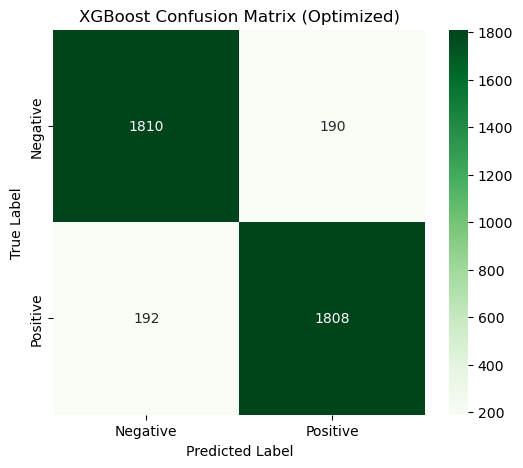


---------------------------------------------------
Model Comparison
---------------------------------------------------
CNN Accuracy: 0.8848
XGBoost Accuracy: 0.9045
XGBoost model performs better and will be used as the primary model.


In [ ]:
# Cell 9
# ---------------------------------------------------
# Train and optimize the XGBoost Classifier
# ---------------------------------------------------

# Split the training data for hyperparameter tuning
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=applied_state, stratify=y_train
)

# Optimize XGBoost hyperparameters
best_xgb_model, best_xgb_params, xgb_val_accuracy = optimize_xgboost(
    X_train_split, y_train_split, X_val, y_val
)

# Train the final model on the full training set
print("Training final XGBoost model on the full training set...")
final_xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=applied_state,
    **best_xgb_params  # Use the best parameters found
)

# Fit on full training set
final_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = final_xgb.predict(X_test)

# Evaluate
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Test Accuracy: {test_accuracy_xgb:.4f}")

# Classification Report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix (Optimized)")
plt.show()

# Compare models and select the best one
print("\n---------------------------------------------------")
print("Model Comparison")
print("---------------------------------------------------")
print(f"CNN Accuracy: {test_accuracy_cnn:.4f}")
print(f"XGBoost Accuracy: {test_accuracy_xgb:.4f}")

# Determine which model performed better
if test_accuracy_cnn > test_accuracy_xgb:
    print("CNN model performs better and will be used as the primary model.")
    primary_model = "CNN"
    best_model = final_cnn
else:
    print("XGBoost model performs better and will be used as the primary model.")
    primary_model = "XGBoost"
    best_model = final_xgb




In [ ]:
#Cell 10
# ---------------------------------------------------
# Save trained models and preprocessing tools
# ---------------------------------------------------

# Save CNN model weights
torch.save(final_cnn.module_.state_dict(), "cnn_model.pth")
print("CNN model saved as 'cnn_model.pth'.")

# Save CNN vocabulary
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
print("Vocabulary saved as 'vocab.pkl'.")

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.")

# Save XGBoost model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(final_xgb, f)
print("XGBoost model saved as 'xgb_model.pkl'.")

# Save the best model parameters
model_comparison = {
    "CNN": {
        "accuracy": test_accuracy_cnn,
        "parameters": best_cnn_params
    },
    "XGBoost": {
        "accuracy": test_accuracy_xgb,
        "parameters": best_xgb_params
    },
    "primary_model": primary_model
}

with open("model_comparison.pkl", "wb") as f:
    pickle.dump(model_comparison, f)
print(f"Model comparison results saved as 'model_comparison.pkl'.")
print(f"Primary model: {primary_model}")



CNN model saved as 'cnn_model.pth'.
Vocabulary saved as 'vocab.pkl'.
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.
XGBoost model saved as 'xgb_model.pkl'.
Model comparison results saved as 'model_comparison.pkl'.
Primary model: XGBoost


SCOPE Review Predictions:

Review: this class was a total mess — lectures never made any sense.
CNN Prediction: Negative
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: great class! i learned a lot and the professor was very helpful.
CNN Prediction: Positive
XGBoost Prediction: Positive
--------------------------------------------------------------------------------
Review: i felt like i was teaching myself most of the time.
CNN Prediction: Negative
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: the group projects were painful but i did enjoy the content.
CNN Prediction: Negative
XGBoost Prediction: Negative
--------------------------------------------------------------------------------
Review: clear grading, fair assignments, and useful material. would recommend.
CNN Prediction: Negative
XGBoost Prediction: Positive
-----------------------------